In [1]:
import torch
import lightning
from mlcolvar.cvs import BaseCV
from mlcolvar.core import FeedForward



In [2]:
import numpy as np
from mlcolvar.data import DictModule, DictDataset
from mlcolvar.utils.io import create_dataset_from_files, load_dataframe
import pandas as pd
import sys
sys.path.append("..")
from loss_and_models import *
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#sample = np.loadtxt("../data/MB/sample_gamma10.dat")[300_000::400]
#bias = np.loadtxt("../data/MB/bias_gamma10.dat")[300_000::400]

sample = np.loadtxt("../../schutte_compare/sample_gamma10.dat")[300_000::400]
bias = np.loadtxt("../../schutte_compare/bias_gamma10.dat")[300_000::400]

/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:

#X = df.filter(regex='p\.[xy]|p[0-9][0-9]\.[abc]')
dataset = DictDataset({"data":sample, "weights":np.exp(bias)})#30
datamodule = DictModule(dataset, lengths=[0.8,0.2],random_split=True,shuffle=True)



In [4]:
dataset["data"] = dataset["data"].to(device)
dataset["weights"] = dataset["weights"].to(device)

In [5]:
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR

options = { 'nn':{'activation':'tanh'},
           'sigmoid':False,
            'optimizer' : {'lr': 5e-3, 'weight_decay': 1e-5}, 
           'sigmoid' :{'deviation' : 0.8 }}
model = Generator(layers=[2,20,20,1],eta=0.05,r=3,gamma=0.0,friction=np.sqrt(1.0/10), options=options)


None


In [6]:
# define callbacks
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

import wandb
from lightning.pytorch.loggers import WandbLogger

# add your batch size to the wandb config
#wandb_logger.experiment.config["batch_size"] = batch_size
metrics = MetricsCallback()
early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=1e-4, patience=500, verbose=False)
# initialize trainer, for testing the number of epochs is low, change this to something like 4/5000
trainer = lightning.Trainer(callbacks=[metrics],#,early_stop_callback], 
                            max_epochs=30000, 
                            enable_checkpointing=False,
                            enable_progress_bar = False #disable progress bar because it made everything bug on my workstation
                            )
# fit model
trainer.fit(model, datamodule)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | GeneratorLoss | 3      | ?        | ?        
1 | nn      | ModuleList    | 1.5 K  | ?        | ?        
-----------------------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-pack

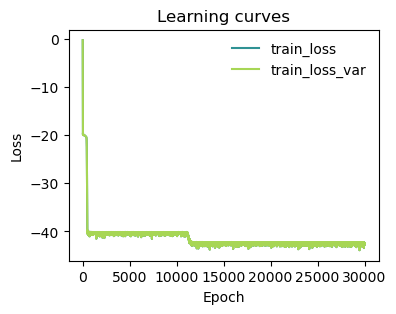

In [7]:
import matplotlib.pyplot as plt
from mlcolvar.utils.plot import plot_metrics, paletteFessa, paletteCortina

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss', 'train_loss_var'],
                  colors=['fessa1', 'fessa3', 'fessa4', 'fessa5'],
                  ax = ax)

In [8]:
model = model.to(device)

In [9]:
from loss_and_models import compute_eigenfunctions
model = model.to(device)
evals, evecs = compute_eigenfunctions(model, dataset, torch.tensor(1/10), 0.05, 3)

In [10]:
0.05 - 1/evals

tensor([-3.6303e-01+0.j, -1.4269e-04+0.j, -7.4506e-09+0.j], device='cuda:0')

In [11]:
psi = model(dataset["data"])

In [12]:
g = psi@ evecs.real

In [13]:
model_zhang = torch.load("models/model_zhang.pt")
deepTICA = torch.load("models/deepTICA.pt")

efuns_zhang = model_zhang(dataset["data"].cpu())
efuns_TICA = deepTICA(dataset["data"].cpu())

/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


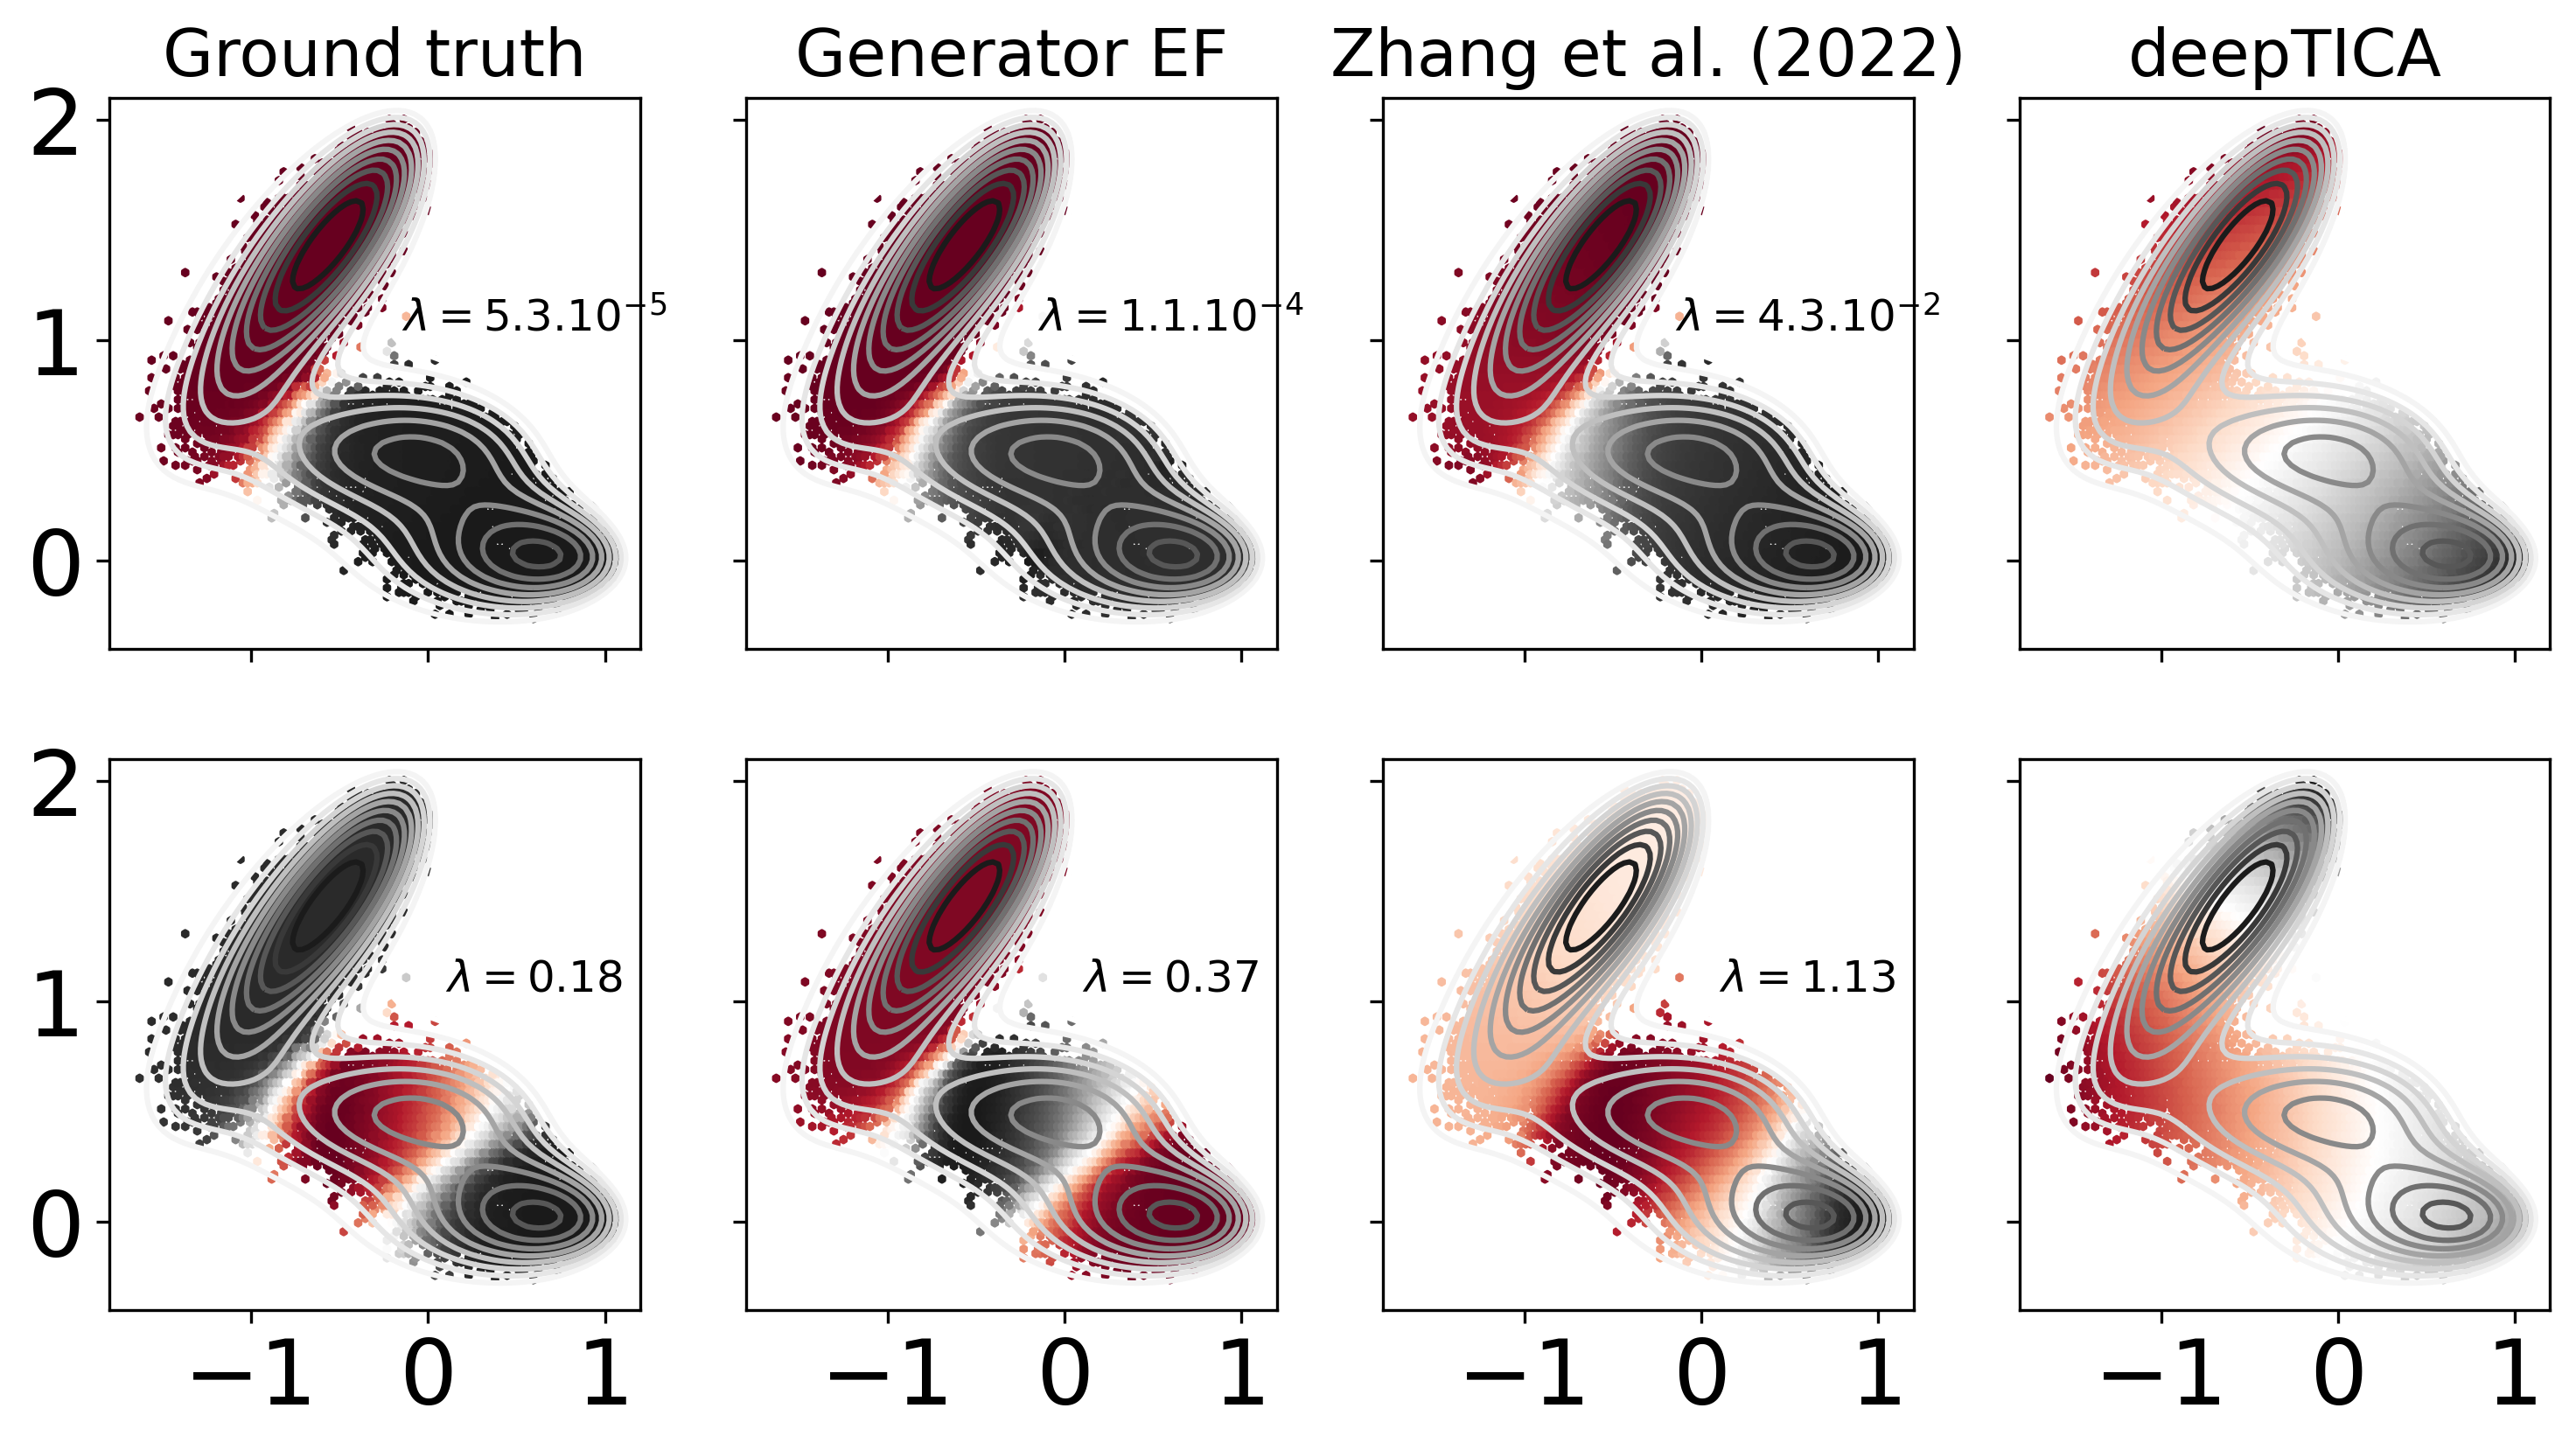

: 

In [14]:
def plot_ef(x,y,ef,ax):
    im = ax.hexbin(x,y,C=ef,cmap="RdGy")#,marker=".")
    return im
def closest_point(x, y):
    closest_points = []
    for point_x in x:
        distances = np.linalg.norm(y - point_x, axis=1)
        closest_index = np.argmin(distances)
        closest_points.append(closest_index)
    return closest_points
from mlcolvar.utils.plot import plot_isolines_2D, muller_brown_potential
efuns = np.loadtxt("/home/tdevergne@iit.local/Documents/generator_learning/muller/models/efuns_MB.dat")
centers = np.loadtxt("/home/tdevergne@iit.local/Documents/generator_learning/muller/models/cell_centers.dat")

closest_points = closest_point(sample, centers)
labels = [-1.5,-1.0,-0.5,0.0,0.5,1.0]
fig, axs = plt.subplots(2,4, figsize=(12,6),sharex=True,sharey=True, dpi=300)
efuns[closest_points][:,1] = -2 * (efuns[closest_points][:,1] - efuns[closest_points][:,1].min()) / (efuns[closest_points][:,1].min() - efuns[closest_points][:,1].max()) - 1
efuns[closest_points,2] = -2 * (efuns[closest_points,2] - efuns[closest_points,2].min()) / (efuns[closest_points,2].min() - efuns[closest_points,2].max()) - 1
g[:,0] = -2 * (g[:,0] - g[:,0].min()) / (g[:,0].min() - g[:,0].max()) - 1
g[:,1] = -2 * (g[:,1] - g[:,1].min()) / (g[:,1].min() - g[:,1].max()) - 1
efuns_zhang[:,0] = -2 * (efuns_zhang[:,0] - efuns_zhang[:,0].min()) / (efuns_zhang[:,0].min() - efuns_zhang[:,0].max()) - 1
efuns_zhang[:,1] = -2 * (efuns_zhang[:,1] - efuns_zhang[:,1].min()) / (efuns_zhang[:,1].min() - efuns_zhang[:,1].max()) - 1



plot_ef(sample[:,0],sample[:,1],efuns[closest_points,1],axs[0,0])
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=axs[0,0])
axs[0,0].text(0.8, 0.6, r"$\lambda=5.3.10^{-5}$", horizontalalignment='center', verticalalignment='center', transform=axs[0,0].transAxes, fontsize=12)


im = plot_ef(sample[:,0],sample[:,1],g[:,1].cpu().detach(),axs[0,1])
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=axs[0,1])
axs[0,1].text(0.8, 0.6, r"$\lambda=1.1.10^{-4}$", horizontalalignment='center', verticalalignment='center', transform=axs[0,1].transAxes,fontsize=12)
#0.8,0.6

plot_ef(sample[:,0],sample[:,1],efuns_zhang[:,0].cpu().detach(),axs[0,2])
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=axs[0,2])
axs[0,2].text(0.8, 0.6, r"$\lambda=4.3.10^{-2}$", horizontalalignment='center', verticalalignment='center', transform=axs[0,2].transAxes,fontsize=12)


plot_ef(sample[:,0],sample[:,1],efuns_TICA[:,0].cpu().detach(),axs[0,3])
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=axs[0,3])

plot_ef(sample[:,0],sample[:,1],efuns[closest_points,2],axs[1,0])
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=axs[1,0])
axs[1,0].text(0.8, 0.6, r"$\lambda=0.18$", horizontalalignment='center', verticalalignment='center', transform=axs[1,0].transAxes,fontsize=12)



plot_ef(sample[:,0],sample[:,1],-g[:,0].cpu().detach(),axs[1,1])
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=axs[1,1])
axs[1,1].text(0.8, 0.6, r"$\lambda=0.37$", horizontalalignment='center', verticalalignment='center', transform=axs[1,1].transAxes,fontsize=12)

plot_ef(sample[:,0],sample[:,1],efuns_zhang[:,1].cpu().detach(),axs[1,2])
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=axs[1,2])
axs[1,2].text(0.8, 0.6, r"$\lambda=1.13$", horizontalalignment='center', verticalalignment='center', transform=axs[1,2].transAxes,fontsize=12)

plot_ef(sample[:,0],sample[:,1],efuns_TICA[:,1].cpu().detach(),axs[1,3])
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=axs[1,3])





#cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust these values to control position and size
#cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')  
#cbar.set_label('Color intensity', fontsize=10)
#cbar.ax.tick_params(labelsize=20)

for arr in axs:
    for ax in arr:
        ax.tick_params(axis='both', which='major', labelsize=25)


cols = ["Ground truth", "Generator EF", "Zhang et al. (2022)", "deepTICA"]
for ax, col in zip(axs[0], cols):
    ax.set_title(col,fontsize=18)